In [26]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
import pandas as pd
import os
from skimage.transform import resize
from skimage.io import imread
import numpy as np
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report



In [41]:
# load the data and preprocess it, set animal class categories
categories = ['dog', 'panda', 'cat']
inputArray=[] #input array
outputArray=[] #output array
datadir='/Users/ejbeazleigh/Downloads/Animals/' 
#path which contains all the categories of images
for i in categories:
    print(f'loading... category : {i}')
    path=os.path.join(datadir,i)
    for img in os.listdir(path):
        img_array=imread(os.path.join(path,img))
        img_resized=resize(img_array,(32,55,3))
        inputArray.append(img_resized)
        outputArray.append(categories.index(i))
    print(f'loaded category:{i} successfully')

loading... category : dog
loaded category:dog successfully
loading... category : panda
loaded category:panda successfully
loading... category : cat
loaded category:cat successfully


In [42]:
#changing shape of data so that it doesnt corrupt the model, 
# printing shapes and integers to double check everythinf is okay and 
#model will not encounter issues
from tensorflow.keras.utils import to_categorical
x=np.array(inputArray, dtype="float")/255.0
y=np.array(outputArray)
print(x.shape)
print(y.shape)
print(x[0])
print(y[0])
y=to_categorical(y,3)
print(y[0])

(3000, 32, 55, 3)
(3000,)
[[[0.00196295 0.00173221 0.00123278]
  [0.00204008 0.00181341 0.00130437]
  [0.00209188 0.0018768  0.00134728]
  ...
  [0.00229087 0.00201031 0.00131412]
  [0.00226211 0.00197151 0.00130621]
  [0.00221604 0.00193571 0.00127183]]

 [[0.00197646 0.0017632  0.00145248]
  [0.00205421 0.00184084 0.00150051]
  [0.00214173 0.00195184 0.00160749]
  ...
  [0.00233112 0.00205281 0.00134987]
  [0.00231051 0.00202804 0.00133726]
  [0.00227616 0.00199043 0.00129365]]

 [[0.00164186 0.00142368 0.00115972]
  [0.00170171 0.00148465 0.00116886]
  [0.00174292 0.00154956 0.00123508]
  ...
  [0.00236031 0.00208347 0.00137612]
  [0.00234529 0.00206836 0.0013612 ]
  [0.00231826 0.00204094 0.00133217]]

 ...

 [[0.00162334 0.00128501 0.00091592]
  [0.00164586 0.00130775 0.00093839]
  [0.00171494 0.00137762 0.00100665]
  ...
  [0.0023652  0.0019961  0.00144252]
  [0.00229669 0.00192759 0.00137382]
  [0.00217746 0.00180782 0.00124993]]

 [[0.00159535 0.00125707 0.00088807]
  [0.001639

In [66]:
CNNmodel = Sequential()

CNNmodel.add(Convolution2D(32, (2,2), activation='relu', input_shape=(32, 55, 3)))
CNNmodel.add(MaxPooling2D(pool_size=(2, 2)))
CNNmodel.add(Convolution2D(64, (2, 2), activation='relu'))
CNNmodel.add(MaxPooling2D(pool_size=(2, 2)))
CNNmodel.add(Dropout(0.25))
CNNmodel.add(Flatten())
CNNmodel.add(Dense(128, activation='relu'))
CNNmodel.add(Dropout(0.5))
CNNmodel.add(Dense(3, activation='softmax'))

CNNmodel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(CNNmodel.summary())

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 31, 54, 32)        416       
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 15, 27, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_33 (Conv2D)          (None, 14, 26, 64)        8256      
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 7, 13, 64)        0         
 g2D)                                                            
                                                                 
 dropout_32 (Dropout)        (None, 7, 13, 64)         0         
                                                                 
 flatten_15 (Flatten)        (None, 5824)            

In [67]:
print(CNNmodel.input_shape)
print(CNNmodel.output_shape)
print(y.shape)


(None, 32, 55, 3)
(None, 3)
(3000, 3)


In [71]:
# the Sequential object in Keras does not have a get_params() method, 
#which is required by scikit-learn's GridSearchCV to overcome this issue below i have 
#create an instance of KerasClassifier, a wrapper for Keras models that enables them to be used in scikit-learn,
#using this function.This will then enable me to get the optimal hyperparamaters for my CNN model
#which i then manually placed into my 'CNNmodelBest'

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
# Define a function that creates your Keras model
def create_model(batch_size=16, epochs=10, optimizer='adam'):
    model = Sequential()
    model.add(Convolution2D(32, (2, 2), activation='relu', input_shape=(32, 55, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Convolution2D(32, (2, 2), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Create an instance of KerasClassifier with your create_model function
keras_model = KerasClassifier(build_fn=create_model)
# Define the parameters to search over
param_grid = {'batch_size': [16, 32, 64],'epochs': [10, 20, 30],'optimizer': ['adam', 'sgd']}
# Create the GridSearchCV object with keras_model as the estimator
grid = GridSearchCV(estimator=keras_model, param_grid=param_grid, scoring=['accuracy', 'f1'], refit='accuracy', cv=3)
# Fit the GridSearchCV object to your data
grid_result = grid.fit(x, y)
# Get the best parameters and the corresponding accuracy and f1 scores
best_params = grid_result.best_params_
print("Best parameters: ", best_params)


/var/folders/h7/pb5zg34j4_x_kt0pszyxqj980000gn/T/ipykernel_38727/867774015.py:20: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_model = KerasClassifier(build_fn=create_model)


Epoch 1/10
125/125 [==============================] - 5s 29ms/step - loss: 0.7438 - accuracy: 0.4930
Epoch 2/10
125/125 [==============================] - 4s 28ms/step - loss: 0.7053 - accuracy: 0.4875
Epoch 3/10
125/125 [==============================] - 3s 25ms/step - loss: 0.7020 - accuracy: 0.5000
Epoch 4/10
125/125 [==============================] - 5s 36ms/step - loss: 0.6977 - accuracy: 0.4895
Epoch 5/10
125/125 [==============================] - 3s 27ms/step - loss: 0.6959 - accuracy: 0.5075
Epoch 6/10
125/125 [==============================] - 3s 21ms/step - loss: 0.6970 - accuracy: 0.5065
Epoch 7/10
125/125 [==============================] - 3s 27ms/step - loss: 0.6938 - accuracy: 0.5215
Epoch 8/10
125/125 [==============================] - 3s 23ms/step - loss: 0.6607 - accuracy: 0.6005
Epoch 9/10
125/125 [==============================] - 2s 19ms/step - loss: 0.5273 - accuracy: 0.7395
Epoch 10/10
32/32 [==============================] - 0s 7ms/step
Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

125/125 [==============================] - 4s 22ms/step - loss: 0.7429 - accuracy: 0.4975
Epoch 2/10
125/125 [==============================] - 3s 22ms/step - loss: 0.7103 - accuracy: 0.4830
Epoch 3/10
125/125 [==============================] - 3s 25ms/step - loss: 0.7042 - accuracy: 0.4895
Epoch 4/10
125/125 [==============================] - 3s 27ms/step - loss: 0.7002 - accuracy: 0.4930
Epoch 5/10
125/125 [==============================] - 3s 21ms/step - loss: 0.6988 - accuracy: 0.4865
Epoch 6/10
125/125 [==============================] - 3s 22ms/step - loss: 0.6978 - accuracy: 0.5025
Epoch 7/10
125/125 [==============================] - 3s 22ms/step - loss: 0.6975 - accuracy: 0.5005
Epoch 8/10
125/125 [==============================] - 3s 21ms/step - loss: 0.6955 - accuracy: 0.5035
Epoch 9/10
125/125 [==============================] - 3s 21ms/step - loss: 0.6964 - accuracy: 0.4970
Epoch 10/10
32/32 [==============================] - 0s 9ms/step
Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

125/125 [==============================] - 4s 22ms/step - loss: 0.7448 - accuracy: 0.4970
Epoch 2/10
125/125 [==============================] - 3s 22ms/step - loss: 0.7053 - accuracy: 0.5005
Epoch 3/10
125/125 [==============================] - 3s 21ms/step - loss: 0.6984 - accuracy: 0.4975
Epoch 4/10
125/125 [==============================] - 3s 20ms/step - loss: 0.6780 - accuracy: 0.5715
Epoch 5/10
125/125 [==============================] - 3s 24ms/step - loss: 0.5824 - accuracy: 0.7150
Epoch 6/10
125/125 [==============================] - 3s 22ms/step - loss: 0.5328 - accuracy: 0.7415
Epoch 7/10
125/125 [==============================] - 3s 21ms/step - loss: 0.4965 - accuracy: 0.7630
Epoch 8/10
125/125 [==============================] - 3s 27ms/step - loss: 0.4885 - accuracy: 0.7720
Epoch 9/10
125/125 [==============================] - 3s 23ms/step - loss: 0.4626 - accuracy: 0.7845
Epoch 10/10
32/32 [==============================] - 0s 9ms/step
Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

125/125 [==============================] - 3s 20ms/step - loss: 0.8708 - accuracy: 0.5045
Epoch 2/10
125/125 [==============================] - 2s 19ms/step - loss: 0.7297 - accuracy: 0.5075
Epoch 3/10
125/125 [==============================] - 2s 17ms/step - loss: 0.7194 - accuracy: 0.5070
Epoch 4/10
125/125 [==============================] - 2s 16ms/step - loss: 0.7125 - accuracy: 0.5060
Epoch 5/10
125/125 [==============================] - 2s 16ms/step - loss: 0.7061 - accuracy: 0.5120
Epoch 6/10
125/125 [==============================] - 2s 18ms/step - loss: 0.7077 - accuracy: 0.4780
Epoch 7/10
125/125 [==============================] - 3s 23ms/step - loss: 0.7040 - accuracy: 0.4940
Epoch 8/10
125/125 [==============================] - 2s 18ms/step - loss: 0.7010 - accuracy: 0.5000
Epoch 9/10
125/125 [==============================] - 2s 19ms/step - loss: 0.7010 - accuracy: 0.5050
Epoch 10/10
32/32 [==============================] - 0s 10ms/step
Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

125/125 [==============================] - 3s 19ms/step - loss: 0.8320 - accuracy: 0.5090
Epoch 2/10
125/125 [==============================] - 2s 19ms/step - loss: 0.7181 - accuracy: 0.4975
Epoch 3/10
125/125 [==============================] - 2s 19ms/step - loss: 0.7061 - accuracy: 0.5055
Epoch 4/10
125/125 [==============================] - 2s 18ms/step - loss: 0.7096 - accuracy: 0.4725
Epoch 5/10
125/125 [==============================] - 2s 18ms/step - loss: 0.7047 - accuracy: 0.4805
Epoch 6/10
125/125 [==============================] - 2s 18ms/step - loss: 0.7019 - accuracy: 0.4790
Epoch 7/10
125/125 [==============================] - 2s 19ms/step - loss: 0.6999 - accuracy: 0.5025
Epoch 8/10
125/125 [==============================] - 2s 19ms/step - loss: 0.7013 - accuracy: 0.4925
Epoch 9/10
125/125 [==============================] - 2s 19ms/step - loss: 0.7004 - accuracy: 0.5100
Epoch 10/10
32/32 [==============================] - 0s 9ms/step
Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

125/125 [==============================] - 4s 18ms/step - loss: 0.8248 - accuracy: 0.4790
Epoch 2/10
125/125 [==============================] - 2s 16ms/step - loss: 0.7278 - accuracy: 0.4915
Epoch 3/10
125/125 [==============================] - 2s 17ms/step - loss: 0.7179 - accuracy: 0.4770
Epoch 4/10
125/125 [==============================] - 2s 16ms/step - loss: 0.7083 - accuracy: 0.4925
Epoch 5/10
125/125 [==============================] - 2s 17ms/step - loss: 0.7048 - accuracy: 0.5050
Epoch 6/10
125/125 [==============================] - 2s 17ms/step - loss: 0.7052 - accuracy: 0.4945
Epoch 7/10
125/125 [==============================] - 2s 17ms/step - loss: 0.7035 - accuracy: 0.4875
Epoch 8/10
125/125 [==============================] - 2s 17ms/step - loss: 0.7006 - accuracy: 0.4940
Epoch 9/10
125/125 [==============================] - 2s 17ms/step - loss: 0.7018 - accuracy: 0.4995
Epoch 10/10
32/32 [==============================] - 0s 8ms/step
Epoch 1/20


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

125/125 [==============================] - 5s 29ms/step - loss: 0.7367 - accuracy: 0.4990
Epoch 2/20
125/125 [==============================] - 3s 24ms/step - loss: 0.7054 - accuracy: 0.4830
Epoch 3/20
125/125 [==============================] - 2s 19ms/step - loss: 0.6983 - accuracy: 0.5080
Epoch 4/20
125/125 [==============================] - 2s 19ms/step - loss: 0.6965 - accuracy: 0.5085
Epoch 5/20
125/125 [==============================] - 2s 19ms/step - loss: 0.6828 - accuracy: 0.5560
Epoch 6/20
125/125 [==============================] - 2s 17ms/step - loss: 0.5651 - accuracy: 0.7225
Epoch 7/20
125/125 [==============================] - 2s 17ms/step - loss: 0.4772 - accuracy: 0.7785
Epoch 8/20
125/125 [==============================] - 4s 30ms/step - loss: 0.4395 - accuracy: 0.8090
Epoch 9/20
125/125 [==============================] - 3s 22ms/step - loss: 0.4253 - accuracy: 0.8045
Epoch 10/20
125/125 [==============================] - 4s 28ms/step - loss: 0.4144 - accuracy: 0.8135


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

125/125 [==============================] - 4s 27ms/step - loss: 0.7540 - accuracy: 0.5065
Epoch 2/20
125/125 [==============================] - 3s 27ms/step - loss: 0.7107 - accuracy: 0.4930
Epoch 3/20
125/125 [==============================] - 3s 28ms/step - loss: 0.7028 - accuracy: 0.4990
Epoch 4/20
125/125 [==============================] - 4s 28ms/step - loss: 0.7013 - accuracy: 0.4885
Epoch 5/20
125/125 [==============================] - 4s 29ms/step - loss: 0.7004 - accuracy: 0.4990
Epoch 6/20
125/125 [==============================] - 3s 28ms/step - loss: 0.6984 - accuracy: 0.4895
Epoch 7/20
125/125 [==============================] - 3s 25ms/step - loss: 0.6961 - accuracy: 0.5020
Epoch 8/20
125/125 [==============================] - 4s 31ms/step - loss: 0.6963 - accuracy: 0.4950
Epoch 9/20
125/125 [==============================] - 3s 21ms/step - loss: 0.6957 - accuracy: 0.5020
Epoch 10/20
125/125 [==============================] - 3s 22ms/step - loss: 0.6948 - accuracy: 0.5005


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

125/125 [==============================] - 5s 27ms/step - loss: 0.7330 - accuracy: 0.5265
Epoch 2/20
125/125 [==============================] - 3s 20ms/step - loss: 0.7088 - accuracy: 0.4855
Epoch 3/20
125/125 [==============================] - 3s 27ms/step - loss: 0.6962 - accuracy: 0.5215
Epoch 4/20
125/125 [==============================] - 4s 29ms/step - loss: 0.6987 - accuracy: 0.5190
Epoch 5/20
125/125 [==============================] - 3s 26ms/step - loss: 0.6829 - accuracy: 0.5560
Epoch 6/20
125/125 [==============================] - 3s 23ms/step - loss: 0.5976 - accuracy: 0.6815
Epoch 7/20
125/125 [==============================] - 2s 19ms/step - loss: 0.5232 - accuracy: 0.7485
Epoch 8/20
125/125 [==============================] - 2s 19ms/step - loss: 0.5026 - accuracy: 0.7590
Epoch 9/20
125/125 [==============================] - 2s 19ms/step - loss: 0.4751 - accuracy: 0.7740
Epoch 10/20
125/125 [==============================] - 3s 20ms/step - loss: 0.4628 - accuracy: 0.7905


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

125/125 [==============================] - 3s 17ms/step - loss: 0.8609 - accuracy: 0.5005
Epoch 2/20
125/125 [==============================] - 2s 18ms/step - loss: 0.7322 - accuracy: 0.4955
Epoch 3/20
125/125 [==============================] - 2s 16ms/step - loss: 0.7196 - accuracy: 0.5025
Epoch 4/20
125/125 [==============================] - 2s 18ms/step - loss: 0.7141 - accuracy: 0.4940
Epoch 5/20
125/125 [==============================] - 2s 18ms/step - loss: 0.7092 - accuracy: 0.5070
Epoch 6/20
125/125 [==============================] - 2s 15ms/step - loss: 0.7085 - accuracy: 0.4960
Epoch 7/20
125/125 [==============================] - 2s 19ms/step - loss: 0.7039 - accuracy: 0.5005
Epoch 8/20
125/125 [==============================] - 3s 26ms/step - loss: 0.7028 - accuracy: 0.4890
Epoch 9/20
125/125 [==============================] - 3s 21ms/step - loss: 0.7042 - accuracy: 0.4940
Epoch 10/20
125/125 [==============================] - 3s 24ms/step - loss: 0.7000 - accuracy: 0.5015


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

125/125 [==============================] - 3s 21ms/step - loss: 0.9183 - accuracy: 0.5135
Epoch 2/20
125/125 [==============================] - 3s 27ms/step - loss: 0.7307 - accuracy: 0.5175
Epoch 3/20
125/125 [==============================] - 2s 16ms/step - loss: 0.7203 - accuracy: 0.5000
Epoch 4/20
125/125 [==============================] - 3s 23ms/step - loss: 0.7095 - accuracy: 0.5070
Epoch 5/20
125/125 [==============================] - 2s 17ms/step - loss: 0.7107 - accuracy: 0.5030
Epoch 6/20
125/125 [==============================] - 2s 16ms/step - loss: 0.7035 - accuracy: 0.5050
Epoch 7/20
125/125 [==============================] - 2s 16ms/step - loss: 0.7083 - accuracy: 0.4875
Epoch 8/20
125/125 [==============================] - 2s 16ms/step - loss: 0.7018 - accuracy: 0.5000
Epoch 9/20
125/125 [==============================] - 4s 29ms/step - loss: 0.7039 - accuracy: 0.4895
Epoch 10/20
125/125 [==============================] - 4s 30ms/step - loss: 0.6997 - accuracy: 0.5035


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

Epoch 1/20
125/125 [==============================] - 3s 19ms/step - loss: 0.8731 - accuracy: 0.4795
Epoch 2/20
125/125 [==============================] - 3s 22ms/step - loss: 0.7428 - accuracy: 0.4860
Epoch 3/20
125/125 [==============================] - 3s 22ms/step - loss: 0.7174 - accuracy: 0.5025
Epoch 4/20
125/125 [==============================] - 3s 23ms/step - loss: 0.7146 - accuracy: 0.4800
Epoch 5/20
125/125 [==============================] - 2s 19ms/step - loss: 0.7048 - accuracy: 0.4975
Epoch 6/20
125/125 [==============================] - 2s 19ms/step - loss: 0.7043 - accuracy: 0.5050
Epoch 7/20
125/125 [==============================] - 3s 23ms/step - loss: 0.7059 - accuracy: 0.5000
Epoch 8/20
125/125 [==============================] - 3s 21ms/step - loss: 0.7020 - accuracy: 0.5050
Epoch 9/20
125/125 [==============================] - 2s 17ms/step - loss: 0.7033 - accuracy: 0.4815
Epoch 10/20
125/125 [==============================] - 2s 17ms/step - loss: 0.6986 - accura

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

125/125 [==============================] - 3s 20ms/step - loss: 0.7552 - accuracy: 0.5095
Epoch 2/30
125/125 [==============================] - 2s 19ms/step - loss: 0.7038 - accuracy: 0.5050
Epoch 3/30
125/125 [==============================] - 2s 19ms/step - loss: 0.7007 - accuracy: 0.4985
Epoch 4/30
125/125 [==============================] - 2s 19ms/step - loss: 0.6976 - accuracy: 0.5035
Epoch 5/30
125/125 [==============================] - 2s 19ms/step - loss: 0.6998 - accuracy: 0.4870
Epoch 6/30
125/125 [==============================] - 2s 19ms/step - loss: 0.6957 - accuracy: 0.5045
Epoch 7/30
125/125 [==============================] - 2s 19ms/step - loss: 0.6938 - accuracy: 0.5230
Epoch 8/30
125/125 [==============================] - 3s 20ms/step - loss: 0.6751 - accuracy: 0.5885
Epoch 9/30
125/125 [==============================] - 2s 19ms/step - loss: 0.5632 - accuracy: 0.7195
Epoch 10/30
125/125 [==============================] - 2s 19ms/step - loss: 0.4820 - accuracy: 0.7685


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

Epoch 1/30
125/125 [==============================] - 5s 29ms/step - loss: 0.7373 - accuracy: 0.5020
Epoch 2/30
125/125 [==============================] - 3s 20ms/step - loss: 0.7026 - accuracy: 0.5005
Epoch 3/30
125/125 [==============================] - 2s 19ms/step - loss: 0.7018 - accuracy: 0.4790
Epoch 4/30
125/125 [==============================] - 2s 19ms/step - loss: 0.6957 - accuracy: 0.5125
Epoch 5/30
125/125 [==============================] - 2s 18ms/step - loss: 0.6985 - accuracy: 0.4855
Epoch 6/30
125/125 [==============================] - 3s 21ms/step - loss: 0.6927 - accuracy: 0.5430
Epoch 7/30
125/125 [==============================] - 2s 19ms/step - loss: 0.6964 - accuracy: 0.4960
Epoch 8/30
125/125 [==============================] - 2s 18ms/step - loss: 0.6963 - accuracy: 0.4930
Epoch 9/30
125/125 [==============================] - 2s 18ms/step - loss: 0.6967 - accuracy: 0.4940
Epoch 10/30
125/125 [==============================] - 3s 22ms/step - loss: 0.6957 - accura

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

Epoch 1/30
125/125 [==============================] - 5s 26ms/step - loss: 0.7467 - accuracy: 0.5125
Epoch 2/30
125/125 [==============================] - 3s 25ms/step - loss: 0.7125 - accuracy: 0.4830
Epoch 3/30
125/125 [==============================] - 4s 29ms/step - loss: 0.6997 - accuracy: 0.5125
Epoch 4/30
125/125 [==============================] - 3s 23ms/step - loss: 0.6407 - accuracy: 0.6420
Epoch 5/30
125/125 [==============================] - 4s 31ms/step - loss: 0.5253 - accuracy: 0.7425
Epoch 6/30
125/125 [==============================] - 2s 19ms/step - loss: 0.4908 - accuracy: 0.7690
Epoch 7/30
125/125 [==============================] - 2s 19ms/step - loss: 0.4673 - accuracy: 0.7805
Epoch 8/30
125/125 [==============================] - 3s 26ms/step - loss: 0.4462 - accuracy: 0.7890
Epoch 9/30
125/125 [==============================] - 3s 26ms/step - loss: 0.4610 - accuracy: 0.7800
Epoch 10/30
125/125 [==============================] - 2s 20ms/step - loss: 0.4338 - accura

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

125/125 [==============================] - 3s 22ms/step - loss: 0.8462 - accuracy: 0.4895
Epoch 2/30
125/125 [==============================] - 3s 25ms/step - loss: 0.7228 - accuracy: 0.4975
Epoch 3/30
125/125 [==============================] - 3s 25ms/step - loss: 0.7117 - accuracy: 0.5230
Epoch 4/30
125/125 [==============================] - 2s 19ms/step - loss: 0.7132 - accuracy: 0.4795
Epoch 5/30
125/125 [==============================] - 2s 18ms/step - loss: 0.7025 - accuracy: 0.5100
Epoch 6/30
125/125 [==============================] - 2s 17ms/step - loss: 0.7025 - accuracy: 0.5160
Epoch 7/30
125/125 [==============================] - 2s 18ms/step - loss: 0.7075 - accuracy: 0.4825
Epoch 8/30
125/125 [==============================] - 2s 17ms/step - loss: 0.7007 - accuracy: 0.5035
Epoch 9/30
125/125 [==============================] - 2s 18ms/step - loss: 0.7025 - accuracy: 0.4980
Epoch 10/30
125/125 [==============================] - 2s 18ms/step - loss: 0.7002 - accuracy: 0.5045


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

125/125 [==============================] - 2s 15ms/step - loss: 0.8956 - accuracy: 0.4955
Epoch 2/30
125/125 [==============================] - 2s 15ms/step - loss: 0.7405 - accuracy: 0.4880
Epoch 3/30
125/125 [==============================] - 2s 15ms/step - loss: 0.7220 - accuracy: 0.4885
Epoch 4/30
125/125 [==============================] - 2s 15ms/step - loss: 0.7111 - accuracy: 0.5040
Epoch 5/30
125/125 [==============================] - 2s 15ms/step - loss: 0.7069 - accuracy: 0.5165
Epoch 6/30
125/125 [==============================] - 2s 16ms/step - loss: 0.7054 - accuracy: 0.4970
Epoch 7/30
125/125 [==============================] - 2s 16ms/step - loss: 0.7061 - accuracy: 0.4830
Epoch 8/30
125/125 [==============================] - 2s 16ms/step - loss: 0.7027 - accuracy: 0.5030
Epoch 9/30
125/125 [==============================] - 2s 15ms/step - loss: 0.7047 - accuracy: 0.4840
Epoch 10/30
125/125 [==============================] - 2s 16ms/step - loss: 0.6999 - accuracy: 0.5100


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

125/125 [==============================] - 3s 18ms/step - loss: 0.8710 - accuracy: 0.5060
Epoch 2/30
125/125 [==============================] - 3s 26ms/step - loss: 0.7249 - accuracy: 0.5190
Epoch 3/30
125/125 [==============================] - 3s 25ms/step - loss: 0.7298 - accuracy: 0.4890
Epoch 4/30
125/125 [==============================] - 4s 29ms/step - loss: 0.7167 - accuracy: 0.4895
Epoch 5/30
125/125 [==============================] - 4s 35ms/step - loss: 0.7068 - accuracy: 0.4975
Epoch 6/30
125/125 [==============================] - 3s 22ms/step - loss: 0.7030 - accuracy: 0.5030
Epoch 7/30
125/125 [==============================] - 3s 21ms/step - loss: 0.7005 - accuracy: 0.4995
Epoch 8/30
125/125 [==============================] - 3s 20ms/step - loss: 0.7035 - accuracy: 0.5170
Epoch 9/30
125/125 [==============================] - 2s 19ms/step - loss: 0.7003 - accuracy: 0.5080
Epoch 10/30
125/125 [==============================] - 2s 19ms/step - loss: 0.7015 - accuracy: 0.5040


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

Epoch 1/10
63/63 [==============================] - 5s 61ms/step - loss: 0.7658 - accuracy: 0.5085
Epoch 2/10
63/63 [==============================] - 3s 49ms/step - loss: 0.7077 - accuracy: 0.4955
Epoch 3/10
63/63 [==============================] - 3s 42ms/step - loss: 0.7013 - accuracy: 0.5070
Epoch 4/10
63/63 [==============================] - 3s 49ms/step - loss: 0.6997 - accuracy: 0.4880
Epoch 5/10
63/63 [==============================] - 2s 35ms/step - loss: 0.6966 - accuracy: 0.5105
Epoch 6/10
63/63 [==============================] - 3s 44ms/step - loss: 0.6925 - accuracy: 0.5225
Epoch 7/10
63/63 [==============================] - 3s 40ms/step - loss: 0.6614 - accuracy: 0.6120
Epoch 8/10
63/63 [==============================] - 3s 48ms/step - loss: 0.5663 - accuracy: 0.7080
Epoch 9/10
63/63 [==============================] - 3s 48ms/step - loss: 0.4821 - accuracy: 0.7725
Epoch 10/10
32/32 [==============================] - 0s 9ms/step
Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

63/63 [==============================] - 4s 49ms/step - loss: 0.7657 - accuracy: 0.4900
Epoch 2/10
63/63 [==============================] - 3s 44ms/step - loss: 0.7064 - accuracy: 0.5075
Epoch 3/10
63/63 [==============================] - 3s 43ms/step - loss: 0.7034 - accuracy: 0.4860
Epoch 4/10
63/63 [==============================] - 3s 48ms/step - loss: 0.7035 - accuracy: 0.4915
Epoch 5/10
63/63 [==============================] - 3s 48ms/step - loss: 0.6973 - accuracy: 0.5080
Epoch 6/10
63/63 [==============================] - 3s 52ms/step - loss: 0.6990 - accuracy: 0.5040
Epoch 7/10
63/63 [==============================] - 3s 49ms/step - loss: 0.6998 - accuracy: 0.4795
Epoch 8/10
63/63 [==============================] - 3s 47ms/step - loss: 0.6961 - accuracy: 0.5020
Epoch 9/10
63/63 [==============================] - 4s 59ms/step - loss: 0.6976 - accuracy: 0.4830
Epoch 10/10
32/32 [==============================] - 0s 9ms/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

Epoch 1/10
63/63 [==============================] - 3s 33ms/step - loss: 0.7784 - accuracy: 0.4910
Epoch 2/10
63/63 [==============================] - 2s 34ms/step - loss: 0.7122 - accuracy: 0.4910
Epoch 3/10
63/63 [==============================] - 2s 34ms/step - loss: 0.7098 - accuracy: 0.5140
Epoch 4/10
63/63 [==============================] - 2s 34ms/step - loss: 0.6980 - accuracy: 0.5070
Epoch 5/10
63/63 [==============================] - 2s 35ms/step - loss: 0.6949 - accuracy: 0.5130
Epoch 6/10
63/63 [==============================] - 2s 33ms/step - loss: 0.6675 - accuracy: 0.6070
Epoch 7/10
63/63 [==============================] - 3s 52ms/step - loss: 0.5495 - accuracy: 0.7330
Epoch 8/10
63/63 [==============================] - 3s 44ms/step - loss: 0.4973 - accuracy: 0.7675
Epoch 9/10
63/63 [==============================] - 3s 50ms/step - loss: 0.4820 - accuracy: 0.7745
Epoch 10/10
32/32 [==============================] - 1s 16ms/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

Epoch 1/10
63/63 [==============================] - 4s 42ms/step - loss: 0.9516 - accuracy: 0.5010
Epoch 2/10
63/63 [==============================] - 3s 41ms/step - loss: 0.7502 - accuracy: 0.4995
Epoch 3/10
63/63 [==============================] - 3s 42ms/step - loss: 0.7364 - accuracy: 0.4855
Epoch 4/10
63/63 [==============================] - 3s 44ms/step - loss: 0.7226 - accuracy: 0.5040
Epoch 5/10
63/63 [==============================] - 2s 37ms/step - loss: 0.7173 - accuracy: 0.5005
Epoch 6/10
63/63 [==============================] - 3s 50ms/step - loss: 0.7123 - accuracy: 0.5090
Epoch 7/10
63/63 [==============================] - 3s 44ms/step - loss: 0.7181 - accuracy: 0.4790
Epoch 8/10
63/63 [==============================] - 4s 56ms/step - loss: 0.7121 - accuracy: 0.4830
Epoch 9/10
63/63 [==============================] - 3s 44ms/step - loss: 0.7108 - accuracy: 0.4800
Epoch 10/10
32/32 [==============================] - 0s 9ms/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

Epoch 1/10
63/63 [==============================] - 3s 33ms/step - loss: 0.9688 - accuracy: 0.4965
Epoch 2/10
63/63 [==============================] - 2s 35ms/step - loss: 0.7601 - accuracy: 0.5010
Epoch 3/10
63/63 [==============================] - 2s 34ms/step - loss: 0.7314 - accuracy: 0.4950
Epoch 4/10
63/63 [==============================] - 2s 33ms/step - loss: 0.7161 - accuracy: 0.4995
Epoch 5/10
63/63 [==============================] - 2s 35ms/step - loss: 0.7138 - accuracy: 0.5000
Epoch 6/10
63/63 [==============================] - 2s 31ms/step - loss: 0.7123 - accuracy: 0.4880
Epoch 7/10
63/63 [==============================] - 2s 29ms/step - loss: 0.7093 - accuracy: 0.5020
Epoch 8/10
63/63 [==============================] - 2s 29ms/step - loss: 0.7071 - accuracy: 0.4985
Epoch 9/10
63/63 [==============================] - 2s 32ms/step - loss: 0.7042 - accuracy: 0.4985
Epoch 10/10
32/32 [==============================] - 1s 16ms/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

Epoch 1/10
63/63 [==============================] - 3s 32ms/step - loss: 0.9906 - accuracy: 0.4980
Epoch 2/10
63/63 [==============================] - 2s 30ms/step - loss: 0.7823 - accuracy: 0.4820
Epoch 3/10
63/63 [==============================] - 2s 31ms/step - loss: 0.7243 - accuracy: 0.5110
Epoch 4/10
63/63 [==============================] - 2s 36ms/step - loss: 0.7156 - accuracy: 0.4970
Epoch 5/10
63/63 [==============================] - 2s 38ms/step - loss: 0.7101 - accuracy: 0.4880
Epoch 6/10
63/63 [==============================] - 3s 49ms/step - loss: 0.7106 - accuracy: 0.4760
Epoch 7/10
63/63 [==============================] - 3s 45ms/step - loss: 0.7084 - accuracy: 0.4835
Epoch 8/10
63/63 [==============================] - 3s 46ms/step - loss: 0.7013 - accuracy: 0.5035
Epoch 9/10
63/63 [==============================] - 4s 55ms/step - loss: 0.7010 - accuracy: 0.5020
Epoch 10/10
32/32 [==============================] - 1s 15ms/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

Epoch 1/20
63/63 [==============================] - 7s 51ms/step - loss: 0.7894 - accuracy: 0.4875
Epoch 2/20
63/63 [==============================] - 3s 54ms/step - loss: 0.7114 - accuracy: 0.4895
Epoch 3/20
63/63 [==============================] - 3s 44ms/step - loss: 0.7057 - accuracy: 0.5035
Epoch 4/20
63/63 [==============================] - 3s 40ms/step - loss: 0.7015 - accuracy: 0.5090
Epoch 5/20
63/63 [==============================] - 2s 34ms/step - loss: 0.6992 - accuracy: 0.4935
Epoch 6/20
63/63 [==============================] - 2s 38ms/step - loss: 0.7018 - accuracy: 0.4820
Epoch 7/20
63/63 [==============================] - 2s 34ms/step - loss: 0.6968 - accuracy: 0.5030
Epoch 8/20
63/63 [==============================] - 2s 34ms/step - loss: 0.6959 - accuracy: 0.5135
Epoch 9/20
63/63 [==============================] - 2s 33ms/step - loss: 0.6947 - accuracy: 0.5035
Epoch 10/20
63/63 [==============================] - 3s 45ms/step - loss: 0.6961 - accuracy: 0.5080
Epoch 11/

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

63/63 [==============================] - 3s 32ms/step - loss: 0.7730 - accuracy: 0.4980
Epoch 2/20
63/63 [==============================] - 2s 33ms/step - loss: 0.7049 - accuracy: 0.5275
Epoch 3/20
63/63 [==============================] - 2s 33ms/step - loss: 0.7096 - accuracy: 0.4765
Epoch 4/20
63/63 [==============================] - 2s 34ms/step - loss: 0.7018 - accuracy: 0.4920
Epoch 5/20
63/63 [==============================] - 3s 44ms/step - loss: 0.6983 - accuracy: 0.4980
Epoch 6/20
63/63 [==============================] - 3s 43ms/step - loss: 0.6986 - accuracy: 0.4870
Epoch 7/20
63/63 [==============================] - 3s 40ms/step - loss: 0.7002 - accuracy: 0.4890
Epoch 8/20
63/63 [==============================] - 3s 52ms/step - loss: 0.6956 - accuracy: 0.5095
Epoch 9/20
63/63 [==============================] - 3s 40ms/step - loss: 0.6999 - accuracy: 0.4810
Epoch 10/20
63/63 [==============================] - 2s 37ms/step - loss: 0.6968 - accuracy: 0.4955
Epoch 11/20
63/63 [=

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

63/63 [==============================] - 3s 35ms/step - loss: 0.7626 - accuracy: 0.5075
Epoch 2/20
63/63 [==============================] - 2s 34ms/step - loss: 0.7026 - accuracy: 0.5085
Epoch 3/20
63/63 [==============================] - 2s 35ms/step - loss: 0.7039 - accuracy: 0.5115
Epoch 4/20
63/63 [==============================] - 2s 36ms/step - loss: 0.6997 - accuracy: 0.4980
Epoch 5/20
63/63 [==============================] - 2s 34ms/step - loss: 0.6956 - accuracy: 0.5075
Epoch 6/20
63/63 [==============================] - 2s 34ms/step - loss: 0.6945 - accuracy: 0.5170
Epoch 7/20
63/63 [==============================] - 2s 34ms/step - loss: 0.6972 - accuracy: 0.5025
Epoch 8/20
63/63 [==============================] - 2s 35ms/step - loss: 0.6962 - accuracy: 0.4860
Epoch 9/20
63/63 [==============================] - 2s 38ms/step - loss: 0.6965 - accuracy: 0.4955
Epoch 10/20
63/63 [==============================] - 2s 35ms/step - loss: 0.6935 - accuracy: 0.5050
Epoch 11/20
63/63 [=

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

63/63 [==============================] - 3s 37ms/step - loss: 0.9714 - accuracy: 0.4955
Epoch 2/20
63/63 [==============================] - 3s 48ms/step - loss: 0.7692 - accuracy: 0.4990
Epoch 3/20
63/63 [==============================] - 2s 32ms/step - loss: 0.7362 - accuracy: 0.4880
Epoch 4/20
63/63 [==============================] - 2s 30ms/step - loss: 0.7181 - accuracy: 0.5115
Epoch 5/20
63/63 [==============================] - 2s 31ms/step - loss: 0.7100 - accuracy: 0.5260
Epoch 6/20
63/63 [==============================] - 2s 30ms/step - loss: 0.7187 - accuracy: 0.4915
Epoch 7/20
63/63 [==============================] - 2s 30ms/step - loss: 0.7129 - accuracy: 0.5155
Epoch 8/20
63/63 [==============================] - 2s 30ms/step - loss: 0.7124 - accuracy: 0.4845
Epoch 9/20
63/63 [==============================] - 2s 31ms/step - loss: 0.7090 - accuracy: 0.4980
Epoch 10/20
63/63 [==============================] - 3s 42ms/step - loss: 0.7084 - accuracy: 0.4960
Epoch 11/20
63/63 [=

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

63/63 [==============================] - 3s 32ms/step - loss: 0.9897 - accuracy: 0.5030
Epoch 2/20
63/63 [==============================] - 2s 31ms/step - loss: 0.7955 - accuracy: 0.4960
Epoch 3/20
63/63 [==============================] - 2s 31ms/step - loss: 0.7423 - accuracy: 0.5085
Epoch 4/20
63/63 [==============================] - 3s 47ms/step - loss: 0.7417 - accuracy: 0.4830
Epoch 5/20
63/63 [==============================] - 3s 48ms/step - loss: 0.7299 - accuracy: 0.4945
Epoch 6/20
63/63 [==============================] - 3s 50ms/step - loss: 0.7161 - accuracy: 0.5105
Epoch 7/20
63/63 [==============================] - 3s 54ms/step - loss: 0.7180 - accuracy: 0.4875
Epoch 8/20
63/63 [==============================] - 3s 43ms/step - loss: 0.7143 - accuracy: 0.5075
Epoch 9/20
63/63 [==============================] - 3s 53ms/step - loss: 0.7047 - accuracy: 0.5110
Epoch 10/20
63/63 [==============================] - 3s 46ms/step - loss: 0.7112 - accuracy: 0.4900
Epoch 11/20
63/63 [=

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

63/63 [==============================] - 3s 32ms/step - loss: 1.0031 - accuracy: 0.5100
Epoch 2/20
63/63 [==============================] - 2s 32ms/step - loss: 0.7959 - accuracy: 0.4900
Epoch 3/20
63/63 [==============================] - 2s 32ms/step - loss: 0.7333 - accuracy: 0.4895
Epoch 4/20
63/63 [==============================] - 2s 33ms/step - loss: 0.7258 - accuracy: 0.4945
Epoch 5/20
63/63 [==============================] - 2s 32ms/step - loss: 0.7149 - accuracy: 0.5100
Epoch 6/20
63/63 [==============================] - 2s 32ms/step - loss: 0.7101 - accuracy: 0.5115
Epoch 7/20
63/63 [==============================] - 2s 33ms/step - loss: 0.7118 - accuracy: 0.4975
Epoch 8/20
63/63 [==============================] - 2s 34ms/step - loss: 0.7095 - accuracy: 0.4915
Epoch 9/20
63/63 [==============================] - 2s 33ms/step - loss: 0.7084 - accuracy: 0.4920
Epoch 10/20
63/63 [==============================] - 2s 32ms/step - loss: 0.7029 - accuracy: 0.5025
Epoch 11/20
63/63 [=

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

63/63 [==============================] - 3s 36ms/step - loss: 0.7683 - accuracy: 0.4830
Epoch 2/30
63/63 [==============================] - 2s 36ms/step - loss: 0.7088 - accuracy: 0.4895
Epoch 3/30
63/63 [==============================] - 2s 36ms/step - loss: 0.7023 - accuracy: 0.4845
Epoch 4/30
63/63 [==============================] - 2s 35ms/step - loss: 0.6971 - accuracy: 0.5055
Epoch 5/30
63/63 [==============================] - 2s 35ms/step - loss: 0.6895 - accuracy: 0.5375
Epoch 6/30
63/63 [==============================] - 2s 36ms/step - loss: 0.6606 - accuracy: 0.6030
Epoch 7/30
63/63 [==============================] - 2s 35ms/step - loss: 0.5603 - accuracy: 0.7220
Epoch 8/30
63/63 [==============================] - 2s 35ms/step - loss: 0.4993 - accuracy: 0.7610
Epoch 9/30
63/63 [==============================] - 2s 36ms/step - loss: 0.4859 - accuracy: 0.7730
Epoch 10/30
63/63 [==============================] - 2s 36ms/step - loss: 0.4669 - accuracy: 0.7795
Epoch 11/30
63/63 [=

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

63/63 [==============================] - 3s 35ms/step - loss: 0.7693 - accuracy: 0.5030
Epoch 2/30
63/63 [==============================] - 2s 35ms/step - loss: 0.7070 - accuracy: 0.5070
Epoch 3/30
63/63 [==============================] - 2s 35ms/step - loss: 0.7111 - accuracy: 0.4890
Epoch 4/30
63/63 [==============================] - 2s 36ms/step - loss: 0.7001 - accuracy: 0.5025
Epoch 5/30
63/63 [==============================] - 2s 35ms/step - loss: 0.7004 - accuracy: 0.5010
Epoch 6/30
63/63 [==============================] - 2s 36ms/step - loss: 0.6979 - accuracy: 0.4900
Epoch 7/30
63/63 [==============================] - 2s 34ms/step - loss: 0.6995 - accuracy: 0.4780
Epoch 8/30
63/63 [==============================] - 2s 38ms/step - loss: 0.6976 - accuracy: 0.4920
Epoch 9/30
63/63 [==============================] - 2s 35ms/step - loss: 0.6969 - accuracy: 0.5060
Epoch 10/30
63/63 [==============================] - 2s 35ms/step - loss: 0.6954 - accuracy: 0.5010
Epoch 11/30
63/63 [=

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

63/63 [==============================] - 3s 36ms/step - loss: 0.7711 - accuracy: 0.4810
Epoch 2/30
63/63 [==============================] - 2s 36ms/step - loss: 0.7049 - accuracy: 0.5235
Epoch 3/30
63/63 [==============================] - 2s 37ms/step - loss: 0.7043 - accuracy: 0.5060
Epoch 4/30
63/63 [==============================] - 2s 35ms/step - loss: 0.6984 - accuracy: 0.5035
Epoch 5/30
63/63 [==============================] - 2s 35ms/step - loss: 0.6971 - accuracy: 0.5185
Epoch 6/30
63/63 [==============================] - 2s 35ms/step - loss: 0.6875 - accuracy: 0.5445
Epoch 7/30
63/63 [==============================] - 2s 37ms/step - loss: 0.6517 - accuracy: 0.6305
Epoch 8/30
63/63 [==============================] - 2s 35ms/step - loss: 0.5423 - accuracy: 0.7315
Epoch 9/30
63/63 [==============================] - 2s 36ms/step - loss: 0.4999 - accuracy: 0.7630
Epoch 10/30
63/63 [==============================] - 2s 35ms/step - loss: 0.4723 - accuracy: 0.7820
Epoch 11/30
63/63 [=

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

63/63 [==============================] - 3s 30ms/step - loss: 0.9819 - accuracy: 0.4980
Epoch 2/30
63/63 [==============================] - 2s 31ms/step - loss: 0.7745 - accuracy: 0.5110
Epoch 3/30
63/63 [==============================] - 2s 31ms/step - loss: 0.7347 - accuracy: 0.5000
Epoch 4/30
63/63 [==============================] - 2s 31ms/step - loss: 0.7261 - accuracy: 0.4910
Epoch 5/30
63/63 [==============================] - 2s 31ms/step - loss: 0.7254 - accuracy: 0.4730
Epoch 6/30
63/63 [==============================] - 2s 31ms/step - loss: 0.7118 - accuracy: 0.4995
Epoch 7/30
63/63 [==============================] - 2s 34ms/step - loss: 0.7110 - accuracy: 0.4930
Epoch 8/30
63/63 [==============================] - 2s 39ms/step - loss: 0.7054 - accuracy: 0.5155
Epoch 9/30
63/63 [==============================] - 2s 34ms/step - loss: 0.7010 - accuracy: 0.5135
Epoch 10/30
63/63 [==============================] - 2s 38ms/step - loss: 0.7071 - accuracy: 0.4840
Epoch 11/30
63/63 [=

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

63/63 [==============================] - 3s 33ms/step - loss: 0.9889 - accuracy: 0.5055
Epoch 2/30
63/63 [==============================] - 2s 39ms/step - loss: 0.7851 - accuracy: 0.5025
Epoch 3/30
63/63 [==============================] - 2s 35ms/step - loss: 0.7421 - accuracy: 0.4880
Epoch 4/30
63/63 [==============================] - 2s 34ms/step - loss: 0.7335 - accuracy: 0.4775
Epoch 5/30
63/63 [==============================] - 2s 32ms/step - loss: 0.7233 - accuracy: 0.4890
Epoch 6/30
63/63 [==============================] - 2s 33ms/step - loss: 0.7170 - accuracy: 0.4945
Epoch 7/30
63/63 [==============================] - 2s 37ms/step - loss: 0.7073 - accuracy: 0.5050
Epoch 8/30
63/63 [==============================] - 2s 39ms/step - loss: 0.7090 - accuracy: 0.4985
Epoch 9/30
63/63 [==============================] - 2s 36ms/step - loss: 0.7117 - accuracy: 0.4835
Epoch 10/30
63/63 [==============================] - 2s 36ms/step - loss: 0.7048 - accuracy: 0.5075
Epoch 11/30
63/63 [=

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

63/63 [==============================] - 3s 35ms/step - loss: 1.0028 - accuracy: 0.4985
Epoch 2/30
63/63 [==============================] - 2s 33ms/step - loss: 0.8013 - accuracy: 0.5060
Epoch 3/30
63/63 [==============================] - 2s 34ms/step - loss: 0.7397 - accuracy: 0.4920
Epoch 4/30
63/63 [==============================] - 3s 50ms/step - loss: 0.7200 - accuracy: 0.5000
Epoch 5/30
63/63 [==============================] - 2s 34ms/step - loss: 0.7197 - accuracy: 0.4870
Epoch 6/30
63/63 [==============================] - 2s 31ms/step - loss: 0.7088 - accuracy: 0.4955
Epoch 7/30
63/63 [==============================] - 2s 31ms/step - loss: 0.7110 - accuracy: 0.4945
Epoch 8/30
63/63 [==============================] - 2s 31ms/step - loss: 0.7055 - accuracy: 0.5055
Epoch 9/30
63/63 [==============================] - 2s 37ms/step - loss: 0.7023 - accuracy: 0.4950
Epoch 10/30
63/63 [==============================] - 2s 32ms/step - loss: 0.7043 - accuracy: 0.4925
Epoch 11/30
63/63 [=

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

Epoch 1/10
32/32 [==============================] - 3s 65ms/step - loss: 0.8163 - accuracy: 0.4980
Epoch 2/10
32/32 [==============================] - 2s 68ms/step - loss: 0.7156 - accuracy: 0.4985
Epoch 3/10
32/32 [==============================] - 2s 69ms/step - loss: 0.7096 - accuracy: 0.4955
Epoch 4/10
32/32 [==============================] - 2s 69ms/step - loss: 0.7025 - accuracy: 0.5100
Epoch 5/10
32/32 [==============================] - 2s 67ms/step - loss: 0.7023 - accuracy: 0.5060
Epoch 6/10
32/32 [==============================] - 2s 67ms/step - loss: 0.6919 - accuracy: 0.5315
Epoch 7/10
32/32 [==============================] - 2s 67ms/step - loss: 0.6826 - accuracy: 0.5540
Epoch 8/10
32/32 [==============================] - 2s 69ms/step - loss: 0.6552 - accuracy: 0.6370
Epoch 9/10
32/32 [==============================] - 2s 67ms/step - loss: 0.5828 - accuracy: 0.7120
Epoch 10/10
32/32 [==============================] - 0s 8ms/step
Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

32/32 [==============================] - 3s 67ms/step - loss: 0.8176 - accuracy: 0.4985
Epoch 2/10
32/32 [==============================] - 2s 69ms/step - loss: 0.7165 - accuracy: 0.5095
Epoch 3/10
32/32 [==============================] - 2s 67ms/step - loss: 0.7074 - accuracy: 0.5055
Epoch 4/10
32/32 [==============================] - 2s 68ms/step - loss: 0.7058 - accuracy: 0.4810
Epoch 5/10
32/32 [==============================] - 2s 67ms/step - loss: 0.6996 - accuracy: 0.5095
Epoch 6/10
32/32 [==============================] - 2s 67ms/step - loss: 0.6975 - accuracy: 0.5160
Epoch 7/10
32/32 [==============================] - 2s 71ms/step - loss: 0.7017 - accuracy: 0.4890
Epoch 8/10
32/32 [==============================] - 2s 67ms/step - loss: 0.6984 - accuracy: 0.4870
Epoch 9/10
32/32 [==============================] - 2s 68ms/step - loss: 0.7011 - accuracy: 0.4935
Epoch 10/10
32/32 [==============================] - 0s 9ms/step
Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

32/32 [==============================] - 3s 68ms/step - loss: 0.8407 - accuracy: 0.5030
Epoch 2/10
32/32 [==============================] - 2s 67ms/step - loss: 0.7221 - accuracy: 0.4945
Epoch 3/10
32/32 [==============================] - 2s 67ms/step - loss: 0.7115 - accuracy: 0.4940
Epoch 4/10
32/32 [==============================] - 2s 67ms/step - loss: 0.7088 - accuracy: 0.4900
Epoch 5/10
32/32 [==============================] - 2s 67ms/step - loss: 0.7033 - accuracy: 0.5040
Epoch 6/10
32/32 [==============================] - 2s 67ms/step - loss: 0.7049 - accuracy: 0.4870
Epoch 7/10
32/32 [==============================] - 2s 66ms/step - loss: 0.7008 - accuracy: 0.5100
Epoch 8/10
32/32 [==============================] - 2s 67ms/step - loss: 0.6973 - accuracy: 0.5030
Epoch 9/10
32/32 [==============================] - 2s 67ms/step - loss: 0.7022 - accuracy: 0.4745
Epoch 10/10
32/32 [==============================] - 0s 9ms/step
Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

32/32 [==============================] - 3s 64ms/step - loss: 1.0508 - accuracy: 0.4955
Epoch 2/10
32/32 [==============================] - 2s 64ms/step - loss: 0.9114 - accuracy: 0.5005
Epoch 3/10
32/32 [==============================] - 2s 64ms/step - loss: 0.7864 - accuracy: 0.4865
Epoch 4/10
32/32 [==============================] - 3s 81ms/step - loss: 0.7515 - accuracy: 0.4915
Epoch 5/10
32/32 [==============================] - 3s 77ms/step - loss: 0.7293 - accuracy: 0.5235
Epoch 6/10
32/32 [==============================] - 3s 83ms/step - loss: 0.7337 - accuracy: 0.4920
Epoch 7/10
32/32 [==============================] - 2s 64ms/step - loss: 0.7279 - accuracy: 0.4920
Epoch 8/10
32/32 [==============================] - 2s 64ms/step - loss: 0.7179 - accuracy: 0.5115
Epoch 9/10
32/32 [==============================] - 2s 66ms/step - loss: 0.7200 - accuracy: 0.4820
Epoch 10/10
32/32 [==============================] - 0s 8ms/step
Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

32/32 [==============================] - 3s 62ms/step - loss: 1.0242 - accuracy: 0.4830
Epoch 2/10
32/32 [==============================] - 2s 64ms/step - loss: 0.8452 - accuracy: 0.5050
Epoch 3/10
32/32 [==============================] - 3s 90ms/step - loss: 0.7529 - accuracy: 0.5025
Epoch 4/10
32/32 [==============================] - 3s 96ms/step - loss: 0.7312 - accuracy: 0.5025
Epoch 5/10
32/32 [==============================] - 3s 96ms/step - loss: 0.7234 - accuracy: 0.4825
Epoch 6/10
32/32 [==============================] - 2s 66ms/step - loss: 0.7204 - accuracy: 0.4965
Epoch 7/10
32/32 [==============================] - 2s 66ms/step - loss: 0.7169 - accuracy: 0.4815
Epoch 8/10
32/32 [==============================] - 2s 65ms/step - loss: 0.7135 - accuracy: 0.4950
Epoch 9/10
32/32 [==============================] - 2s 65ms/step - loss: 0.7088 - accuracy: 0.4940
Epoch 10/10
32/32 [==============================] - 0s 9ms/step
Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

32/32 [==============================] - 3s 65ms/step - loss: 1.0176 - accuracy: 0.5090
Epoch 2/10
32/32 [==============================] - 2s 64ms/step - loss: 0.8480 - accuracy: 0.4965
Epoch 3/10
32/32 [==============================] - 2s 64ms/step - loss: 0.7694 - accuracy: 0.4985
Epoch 4/10
32/32 [==============================] - 2s 67ms/step - loss: 0.7606 - accuracy: 0.4865
Epoch 5/10
32/32 [==============================] - 2s 64ms/step - loss: 0.7478 - accuracy: 0.5045
Epoch 6/10
32/32 [==============================] - 2s 66ms/step - loss: 0.7439 - accuracy: 0.4970
Epoch 7/10
32/32 [==============================] - 2s 65ms/step - loss: 0.7272 - accuracy: 0.5090
Epoch 8/10
32/32 [==============================] - 2s 64ms/step - loss: 0.7236 - accuracy: 0.5035
Epoch 9/10
32/32 [==============================] - 2s 64ms/step - loss: 0.7238 - accuracy: 0.4880
Epoch 10/10
32/32 [==============================] - 0s 10ms/step
Epoch 1/20


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

32/32 [==============================] - 3s 66ms/step - loss: 0.8208 - accuracy: 0.4815
Epoch 2/20
32/32 [==============================] - 2s 66ms/step - loss: 0.7182 - accuracy: 0.4915
Epoch 3/20
32/32 [==============================] - 2s 67ms/step - loss: 0.7039 - accuracy: 0.5115
Epoch 4/20
32/32 [==============================] - 2s 66ms/step - loss: 0.7018 - accuracy: 0.5060
Epoch 5/20
32/32 [==============================] - 2s 67ms/step - loss: 0.7012 - accuracy: 0.5235
Epoch 6/20
32/32 [==============================] - 2s 66ms/step - loss: 0.6962 - accuracy: 0.5175
Epoch 7/20
32/32 [==============================] - 2s 66ms/step - loss: 0.6890 - accuracy: 0.5530
Epoch 8/20
32/32 [==============================] - 2s 67ms/step - loss: 0.6691 - accuracy: 0.5920
Epoch 9/20
32/32 [==============================] - 2s 67ms/step - loss: 0.6289 - accuracy: 0.6575
Epoch 10/20
32/32 [==============================] - 2s 67ms/step - loss: 0.5787 - accuracy: 0.7155
Epoch 11/20
32/32 [=

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

32/32 [==============================] - 3s 64ms/step - loss: 0.8118 - accuracy: 0.4935
Epoch 2/20
32/32 [==============================] - 2s 68ms/step - loss: 0.7186 - accuracy: 0.5100
Epoch 3/20
32/32 [==============================] - 2s 67ms/step - loss: 0.7142 - accuracy: 0.4925
Epoch 4/20
32/32 [==============================] - 2s 66ms/step - loss: 0.7009 - accuracy: 0.5090
Epoch 5/20
32/32 [==============================] - 3s 85ms/step - loss: 0.7005 - accuracy: 0.5120
Epoch 6/20
32/32 [==============================] - 3s 99ms/step - loss: 0.7065 - accuracy: 0.4925
Epoch 7/20
32/32 [==============================] - 3s 84ms/step - loss: 0.6985 - accuracy: 0.5010
Epoch 8/20
32/32 [==============================] - 2s 70ms/step - loss: 0.7002 - accuracy: 0.4985
Epoch 9/20
32/32 [==============================] - 3s 88ms/step - loss: 0.6979 - accuracy: 0.4855
Epoch 10/20
32/32 [==============================] - 2s 74ms/step - loss: 0.6972 - accuracy: 0.4890
Epoch 11/20
32/32 [=

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

32/32 [==============================] - 5s 62ms/step - loss: 0.8058 - accuracy: 0.4945
Epoch 2/20
32/32 [==============================] - 2s 66ms/step - loss: 0.7155 - accuracy: 0.4960
Epoch 3/20
32/32 [==============================] - 2s 69ms/step - loss: 0.7030 - accuracy: 0.5070
Epoch 4/20
32/32 [==============================] - 2s 66ms/step - loss: 0.7041 - accuracy: 0.4960
Epoch 5/20
32/32 [==============================] - 2s 64ms/step - loss: 0.6976 - accuracy: 0.5210
Epoch 6/20
32/32 [==============================] - 2s 63ms/step - loss: 0.6948 - accuracy: 0.5305
Epoch 7/20
32/32 [==============================] - 2s 64ms/step - loss: 0.6821 - accuracy: 0.5705
Epoch 8/20
32/32 [==============================] - 2s 65ms/step - loss: 0.6482 - accuracy: 0.6460
Epoch 9/20
32/32 [==============================] - 2s 66ms/step - loss: 0.5934 - accuracy: 0.6900
Epoch 10/20
32/32 [==============================] - 2s 71ms/step - loss: 0.5175 - accuracy: 0.7650
Epoch 11/20
32/32 [=

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

32/32 [==============================] - 3s 65ms/step - loss: 1.0506 - accuracy: 0.4825
Epoch 2/20
32/32 [==============================] - 2s 66ms/step - loss: 0.9277 - accuracy: 0.4910
Epoch 3/20
32/32 [==============================] - 2s 68ms/step - loss: 0.8058 - accuracy: 0.5095
Epoch 4/20
32/32 [==============================] - 2s 67ms/step - loss: 0.7615 - accuracy: 0.4935
Epoch 5/20
32/32 [==============================] - 2s 63ms/step - loss: 0.7449 - accuracy: 0.4980
Epoch 6/20
32/32 [==============================] - 2s 63ms/step - loss: 0.7316 - accuracy: 0.5065
Epoch 7/20
32/32 [==============================] - 2s 62ms/step - loss: 0.7285 - accuracy: 0.5105
Epoch 8/20
32/32 [==============================] - 2s 63ms/step - loss: 0.7292 - accuracy: 0.4780
Epoch 9/20
32/32 [==============================] - 2s 62ms/step - loss: 0.7192 - accuracy: 0.4895
Epoch 10/20
32/32 [==============================] - 2s 63ms/step - loss: 0.7246 - accuracy: 0.4875
Epoch 11/20
32/32 [=

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

32/32 [==============================] - 3s 65ms/step - loss: 1.0582 - accuracy: 0.4860
Epoch 2/20
32/32 [==============================] - 2s 61ms/step - loss: 0.9713 - accuracy: 0.4905
Epoch 3/20
32/32 [==============================] - 2s 73ms/step - loss: 0.8616 - accuracy: 0.5160
Epoch 4/20
32/32 [==============================] - 3s 85ms/step - loss: 0.7872 - accuracy: 0.4945
Epoch 5/20
32/32 [==============================] - 2s 65ms/step - loss: 0.7589 - accuracy: 0.5010
Epoch 6/20
32/32 [==============================] - 2s 62ms/step - loss: 0.7491 - accuracy: 0.4950
Epoch 7/20
32/32 [==============================] - 2s 63ms/step - loss: 0.7426 - accuracy: 0.4860
Epoch 8/20
32/32 [==============================] - 2s 63ms/step - loss: 0.7310 - accuracy: 0.4980
Epoch 9/20
32/32 [==============================] - 2s 65ms/step - loss: 0.7348 - accuracy: 0.4875
Epoch 10/20
32/32 [==============================] - 2s 64ms/step - loss: 0.7279 - accuracy: 0.4865
Epoch 11/20
32/32 [=

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

32/32 [==============================] - 2s 59ms/step - loss: 1.0469 - accuracy: 0.4960
Epoch 2/20
32/32 [==============================] - 2s 60ms/step - loss: 0.9196 - accuracy: 0.4895
Epoch 3/20
32/32 [==============================] - 2s 62ms/step - loss: 0.7983 - accuracy: 0.4915
Epoch 4/20
32/32 [==============================] - 2s 60ms/step - loss: 0.7574 - accuracy: 0.4890
Epoch 5/20
32/32 [==============================] - 2s 61ms/step - loss: 0.7332 - accuracy: 0.5070
Epoch 6/20
32/32 [==============================] - 2s 61ms/step - loss: 0.7327 - accuracy: 0.4995
Epoch 7/20
32/32 [==============================] - 2s 61ms/step - loss: 0.7300 - accuracy: 0.4920
Epoch 8/20
32/32 [==============================] - 2s 74ms/step - loss: 0.7170 - accuracy: 0.5155
Epoch 9/20
32/32 [==============================] - 2s 65ms/step - loss: 0.7114 - accuracy: 0.5175
Epoch 10/20
32/32 [==============================] - 2s 67ms/step - loss: 0.7183 - accuracy: 0.5035
Epoch 11/20
32/32 [=

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

Epoch 1/30
32/32 [==============================] - 4s 71ms/step - loss: 0.8316 - accuracy: 0.4850
Epoch 2/30
32/32 [==============================] - 2s 63ms/step - loss: 0.7100 - accuracy: 0.5190
Epoch 3/30
32/32 [==============================] - 2s 63ms/step - loss: 0.7000 - accuracy: 0.5200
Epoch 4/30
32/32 [==============================] - 2s 63ms/step - loss: 0.7027 - accuracy: 0.5085
Epoch 5/30
32/32 [==============================] - 3s 83ms/step - loss: 0.7023 - accuracy: 0.5025
Epoch 6/30
32/32 [==============================] - 2s 65ms/step - loss: 0.6946 - accuracy: 0.5320
Epoch 7/30
32/32 [==============================] - 2s 64ms/step - loss: 0.6976 - accuracy: 0.5055
Epoch 8/30
32/32 [==============================] - 2s 73ms/step - loss: 0.6938 - accuracy: 0.5245
Epoch 9/30
32/32 [==============================] - 2s 73ms/step - loss: 0.6835 - accuracy: 0.5590
Epoch 10/30
32/32 [==============================] - 2s 65ms/step - loss: 0.6571 - accuracy: 0.6210
Epoch 11/

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

32/32 [==============================] - 3s 62ms/step - loss: 0.8200 - accuracy: 0.4800
Epoch 2/30
32/32 [==============================] - 2s 66ms/step - loss: 0.7153 - accuracy: 0.5025
Epoch 3/30
32/32 [==============================] - 2s 63ms/step - loss: 0.7103 - accuracy: 0.4960
Epoch 4/30
32/32 [==============================] - 2s 63ms/step - loss: 0.7048 - accuracy: 0.4990
Epoch 5/30
32/32 [==============================] - 2s 63ms/step - loss: 0.6997 - accuracy: 0.5110
Epoch 6/30
32/32 [==============================] - 2s 63ms/step - loss: 0.6998 - accuracy: 0.4990
Epoch 7/30
32/32 [==============================] - 2s 65ms/step - loss: 0.6959 - accuracy: 0.5185
Epoch 8/30
32/32 [==============================] - 2s 63ms/step - loss: 0.6963 - accuracy: 0.5070
Epoch 9/30
32/32 [==============================] - 2s 64ms/step - loss: 0.6975 - accuracy: 0.5140
Epoch 10/30
32/32 [==============================] - 2s 63ms/step - loss: 0.6966 - accuracy: 0.5035
Epoch 11/30
32/32 [=

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

32/32 [==============================] - 3s 63ms/step - loss: 0.8114 - accuracy: 0.4740
Epoch 2/30
32/32 [==============================] - 2s 63ms/step - loss: 0.7103 - accuracy: 0.4890
Epoch 3/30
32/32 [==============================] - 2s 63ms/step - loss: 0.7056 - accuracy: 0.5045
Epoch 4/30
32/32 [==============================] - 2s 63ms/step - loss: 0.7028 - accuracy: 0.4870
Epoch 5/30
32/32 [==============================] - 2s 65ms/step - loss: 0.6944 - accuracy: 0.5270
Epoch 6/30
32/32 [==============================] - 2s 64ms/step - loss: 0.6876 - accuracy: 0.5425
Epoch 7/30
32/32 [==============================] - 2s 64ms/step - loss: 0.6715 - accuracy: 0.6025
Epoch 8/30
32/32 [==============================] - 2s 63ms/step - loss: 0.6193 - accuracy: 0.6850
Epoch 9/30
32/32 [==============================] - 2s 63ms/step - loss: 0.5481 - accuracy: 0.7305
Epoch 10/30
32/32 [==============================] - 2s 65ms/step - loss: 0.5042 - accuracy: 0.7655
Epoch 11/30
32/32 [=

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

32/32 [==============================] - 3s 62ms/step - loss: 1.0296 - accuracy: 0.4880
Epoch 2/30
32/32 [==============================] - 2s 61ms/step - loss: 0.8597 - accuracy: 0.4890
Epoch 3/30
32/32 [==============================] - 2s 61ms/step - loss: 0.7537 - accuracy: 0.5135
Epoch 4/30
32/32 [==============================] - 2s 65ms/step - loss: 0.7276 - accuracy: 0.4990
Epoch 5/30
32/32 [==============================] - 2s 63ms/step - loss: 0.7173 - accuracy: 0.5060
Epoch 6/30
32/32 [==============================] - 2s 62ms/step - loss: 0.7131 - accuracy: 0.4965
Epoch 7/30
32/32 [==============================] - 2s 63ms/step - loss: 0.7120 - accuracy: 0.5025
Epoch 8/30
32/32 [==============================] - 2s 68ms/step - loss: 0.7112 - accuracy: 0.4900
Epoch 9/30
32/32 [==============================] - 2s 65ms/step - loss: 0.7098 - accuracy: 0.4925
Epoch 10/30
32/32 [==============================] - 2s 63ms/step - loss: 0.7073 - accuracy: 0.4835
Epoch 11/30
32/32 [=

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

32/32 [==============================] - 3s 62ms/step - loss: 1.0377 - accuracy: 0.5105
Epoch 2/30
32/32 [==============================] - 2s 64ms/step - loss: 0.8854 - accuracy: 0.5210
Epoch 3/30
32/32 [==============================] - 2s 66ms/step - loss: 0.7792 - accuracy: 0.5135
Epoch 4/30
32/32 [==============================] - 2s 66ms/step - loss: 0.7511 - accuracy: 0.4900
Epoch 5/30
32/32 [==============================] - 2s 72ms/step - loss: 0.7428 - accuracy: 0.4870
Epoch 6/30
32/32 [==============================] - 2s 71ms/step - loss: 0.7341 - accuracy: 0.4825
Epoch 7/30
32/32 [==============================] - 2s 68ms/step - loss: 0.7319 - accuracy: 0.4960
Epoch 8/30
32/32 [==============================] - 2s 65ms/step - loss: 0.7186 - accuracy: 0.5070
Epoch 9/30
32/32 [==============================] - 2s 65ms/step - loss: 0.7203 - accuracy: 0.4910
Epoch 10/30
32/32 [==============================] - 2s 64ms/step - loss: 0.7132 - accuracy: 0.5055
Epoch 11/30
32/32 [=

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

32/32 [==============================] - 3s 62ms/step - loss: 1.0429 - accuracy: 0.4840
Epoch 2/30
32/32 [==============================] - 2s 66ms/step - loss: 0.9004 - accuracy: 0.4995
Epoch 3/30
32/32 [==============================] - 2s 69ms/step - loss: 0.7917 - accuracy: 0.5055
Epoch 4/30
32/32 [==============================] - 2s 68ms/step - loss: 0.7568 - accuracy: 0.5135
Epoch 5/30
32/32 [==============================] - 3s 84ms/step - loss: 0.7499 - accuracy: 0.4780
Epoch 6/30
32/32 [==============================] - 3s 87ms/step - loss: 0.7350 - accuracy: 0.4910
Epoch 7/30
32/32 [==============================] - 3s 98ms/step - loss: 0.7309 - accuracy: 0.4855
Epoch 8/30
32/32 [==============================] - 3s 100ms/step - loss: 0.7297 - accuracy: 0.4825
Epoch 9/30
32/32 [==============================] - 2s 70ms/step - loss: 0.7223 - accuracy: 0.4930
Epoch 10/30
32/32 [==============================] - 3s 98ms/step - loss: 0.7171 - accuracy: 0.4875
Epoch 11/30
32/32 [

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

188/188 [==============================] - 4s 20ms/step - loss: 1.0992 - accuracy: 0.3363
Epoch 2/10
188/188 [==============================] - 4s 19ms/step - loss: 1.0990 - accuracy: 0.3203
Epoch 3/10
188/188 [==============================] - 4s 19ms/step - loss: 1.0986 - accuracy: 0.3313
Epoch 4/10
188/188 [==============================] - 4s 20ms/step - loss: 1.0990 - accuracy: 0.3243
Epoch 5/10
188/188 [==============================] - 4s 20ms/step - loss: 1.0989 - accuracy: 0.3207
Epoch 6/10
188/188 [==============================] - 4s 20ms/step - loss: 1.0987 - accuracy: 0.3247
Epoch 7/10
188/188 [==============================] - 4s 20ms/step - loss: 1.0986 - accuracy: 0.3413
Epoch 8/10
188/188 [==============================] - 4s 20ms/step - loss: 1.0987 - accuracy: 0.3437
Epoch 9/10
188/188 [==============================] - 4s 20ms/step - loss: 1.0987 - accuracy: 0.3347
Epoch 10/10
188/188 [==============================] - 4s 20ms/step - loss: 1.0988 - accuracy: 0.3133


In [77]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
#output from last cell : "Best parameters:  {'batch_size': 16, 'epochs': 10, 'optimizer': 'adam'}"

# Create a new Sequential model with the best parameters
CNNmodelbest = Sequential()

CNNmodelbest.add(Convolution2D(32, (2, 2), activation='relu', input_shape=(32, 55, 3)))
CNNmodelbest.add(MaxPooling2D(pool_size=(2, 2)))
CNNmodelbest.add(Convolution2D(32, (2, 2), activation='relu'))
CNNmodelbest.add(MaxPooling2D(pool_size=(2, 2)))
CNNmodelbest.add(Dropout(0.25))
CNNmodelbest.add(Flatten())
CNNmodelbest.add(Dense(128, activation='relu'))
CNNmodelbest.add(Dropout(0.5))
CNNmodelbest.add(Dense(3, activation='softmax'))

CNNmodelbest.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])




In [81]:
#y = y.reshape((x.shape[0], 1))
#y = np.argmax(y, axis=1)


print(x.shape)
print(y.shape)
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score,f1_score, confusion_matrix 
import seaborn as sns 
from sklearn.model_selection import KFold

f1List = []
accuracyList = []
cmList = []

#initialize the sk-fold 4 crossval with nsplits defining the no. of folds in this case 10 
kf = KFold(n_splits=10, shuffle=True, random_state=42)

for fold, (train_index, val_index) in enumerate(kf.split(x, y)):
    trainX, trainY = x[train_index],y[train_index]
    valX, valY = x[val_index], y[val_index]
    #fit model on training data
    CNNmodelbest.fit(trainX, trainY, batch_size=16, epochs=10)
    # Evaluate the model on the validation set
    loss, acc = CNNmodelbest.evaluate(valX, valY, verbose=0)
    predY = CNNmodelbest.predict(valX)
    f1 = f1_score(valY.argmax(axis=1),predY.argmax(axis=1),average='macro')
    accuracyList.append(acc)
    f1List.append(f1)
    cm = confusion_matrix(valY.argmax(axis=1),predY.argmax(axis=1))
    cmList.append(cm)
    print(f"Fold{fold+1}:accuracy = {acc}, f1score = {f1}")

(3000, 32, 55, 3)
(3000, 3)
Epoch 1/10
169/169 [==============================] - 3s 20ms/step - loss: 1.0989 - accuracy: 0.3307
Epoch 2/10
169/169 [==============================] - 4s 22ms/step - loss: 1.0988 - accuracy: 0.3200
Epoch 3/10
169/169 [==============================] - 3s 19ms/step - loss: 1.0988 - accuracy: 0.3241
Epoch 4/10
169/169 [==============================] - 4s 22ms/step - loss: 1.0987 - accuracy: 0.3244
Epoch 5/10
169/169 [==============================] - 3s 19ms/step - loss: 1.0987 - accuracy: 0.3244
Epoch 6/10
169/169 [==============================] - 3s 20ms/step - loss: 1.0987 - accuracy: 0.3359
Epoch 7/10
169/169 [==============================] - 3s 20ms/step - loss: 1.0987 - accuracy: 0.3248
Epoch 8/10
169/169 [==============================] - 3s 20ms/step - loss: 1.0987 - accuracy: 0.3359
Epoch 9/10
169/169 [==============================] - 3s 20ms/step - loss: 1.0987 - accuracy: 0.3359
Epoch 10/10
10/10 [==============================] - 0s 20ms/st

169/169 [==============================] - 8s 46ms/step - loss: 1.0988 - accuracy: 0.3256
Epoch 4/10
169/169 [==============================] - 8s 46ms/step - loss: 1.0987 - accuracy: 0.3352
Epoch 5/10
169/169 [==============================] - 6s 38ms/step - loss: 1.0987 - accuracy: 0.3352
Epoch 6/10
169/169 [==============================] - 6s 34ms/step - loss: 1.0988 - accuracy: 0.3274
Epoch 7/10
169/169 [==============================] - 6s 33ms/step - loss: 1.0988 - accuracy: 0.3248
Epoch 8/10
169/169 [==============================] - 6s 33ms/step - loss: 1.0988 - accuracy: 0.3200
Epoch 9/10
169/169 [==============================] - 6s 33ms/step - loss: 1.0987 - accuracy: 0.3204
Epoch 10/10
10/10 [==============================] - 0s 14ms/step
Fold8:accuracy = 0.3166666626930237, f1score = 0.16033755274261605
Epoch 1/10
169/169 [==============================] - 6s 33ms/step - loss: 1.0988 - accuracy: 0.3352
Epoch 2/10
169/169 [==============================] - 5s 31ms/step - l

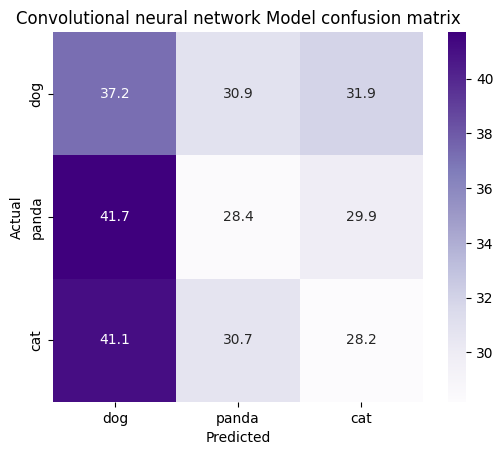

<Figure size 640x480 with 0 Axes>

Mean Accuracy: 0.31266666352748873
Mean f1 Score: 0.158754072589611


In [79]:
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,f1_score, confusion_matrix 
import seaborn as sns 

mean_acc = sum(accuracyList)/len(accuracyList)
mean_f1 = sum(f1List)/len(f1List)
meanCM = sum(cmList)/len(cmList)

ax = plt.axes()
sns.heatmap(meanCM,ax=ax,annot=True,fmt='g',cmap='Purples',square=True)
fig = plt.figure()
fig.patch.set_facecolor('xkcd:grey')
ax.set_title('Convolutional neural network Model confusion matrix')
ax.set_xticklabels(categories)
ax.set_yticklabels(categories)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.show()
print(f"Mean Accuracy: {mean_acc}")
print(f"Mean f1 Score: {mean_f1}")